# Data reclassification

Reclassifying data based on specific criteria is a common task when doing GIS analysis. The purpose of this lesson is to see how we can reclassify values based on some criteria which can be whatever, such as:

```
1. if travel time to my work is less than 30 minutes

    AND

    2. the rent of the apartment is less than 1000 € per month

    ------------------------------------------------------

    IF TRUE: ==> I go to view it and try to rent the apartment
    IF NOT TRUE: ==> I continue looking for something else
```

In this tutorial, we will use Travel Time Matrix data from Helsinki to classify some features of the data based on map classifiers that are commonly used e.g. when doing visualizations, and our own self-made classifier where we determine how the data should be classified.

1. use ready made classifiers from pysal -module to classify travel times into multiple classes.

2. use travel times and distances to find out

   - good locations to buy an apartment with good public transport accessibility to city center
   - but from a bit further away from city center where the prices are presumably lower.

*Note, during this intensive course we won't be using the Corine2012 data.*

## Download data

For this lesson, you should [download a data package](https://github.com/AutoGIS/data/raw/master/L4_data.zip) that includes 3 files:

 1. Helsinki_borders.shp
 2. Travel_times_to_5975375_RailwayStation.shp
 3. Amazon_river.shp
 
```
$ cd /home/jovyan/notebooks/L4
$ wget https://github.com/AutoGIS/data/raw/master/L4_data.zip
$ unzip L4_data.zip
```

## Classifying data

### Classification based on common classifiers

[Pysal](http://pysal.readthedocs.io/en/latest) -module is an extensive Python library including various functions and tools to do spatial data analysis. It also includes all of the most common data classifiers that are used commonly e.g. when visualizing data. Available map classifiers in pysal -module are ([see here for more details](http://pysal.readthedocs.io/en/latest/library/esda/mapclassify.html)):

 - Box_Plot
 - Equal_Interval
 - Fisher_Jenks
 - Fisher_Jenks_Sampled
 - HeadTail_Breaks
 - Jenks_Caspall
 - Jenks_Caspall_Forced
 - Jenks_Caspall_Sampled
 - Max_P_Classifier
 - Maximum_Breaks
 - Natural_Breaks
 - Quantiles
 - Percentiles
 - Std_Mean
 - User_Defined

- First, we need to read our Travel Time data from Helsinki into memory from a GeoJSON file.

In [3]:
import geopandas as gpd

fp = "data/TravelTimes_to_5975375_RailwayStation.shp"

# Read the GeoJSON file similarly as Shapefile
acc = gpd.read_file(fp)

# Let's see what we have
print(acc.head(2))

   car_m_d  car_m_t  car_r_d  car_r_t  from_id  pt_m_d  pt_m_t  pt_m_tt  \
0    32297       43    32260       48  5785640   32616     116      147   
1    32508       43    32471       49  5785641   32822     119      145   

   pt_r_d  pt_r_t  pt_r_tt    to_id  walk_d  walk_t  \
0   32616     108      139  5975375   32164     459   
1   32822     111      133  5975375   29547     422   

                                            geometry  
0  POLYGON ((382000.0001358641 6697750.000038058,...  
1  POLYGON ((382250.0001358146 6697750.000038053,...  


As we can see, there exist plenty of different variables (see [from here the description](http://blogs.helsinki.fi/accessibility/helsinki-region-travel-time-matrix-2015) for all attributes) but what we are interested in are columns called `pt_r_tt` which is telling the time in minutes that it takes to reach city center from different parts of the city, and `walk_d` that tells the network distance by roads to reach city center from different parts of the city (almost equal to Euclidian distance).

**The NoData values are presented with value -1**. 

- Thus we need to remove the No Data values first.


In [4]:
# Include only data that is above or equal to 0
acc = acc.loc[acc['pt_r_tt'] >=0]

- Let's plot the data and see how it looks like.

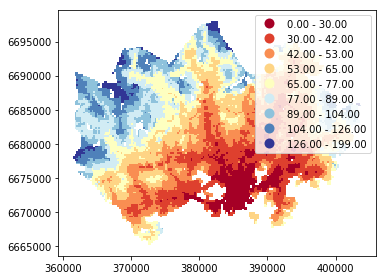

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot using 9 classes and classify the values using "Fisher Jenks" classification
acc.plot(column="pt_r_tt", scheme="Fisher_Jenks", k=9, cmap="RdYlBu", linewidth=0, legend=True)

# Use tight layout
plt.tight_layout()

As we can see from this map, the travel times are lower in the south where the city center is located but there are some areas of "good" accessibility also in some other areas (where the color is red).

- Let's also make a plot about walking distances:

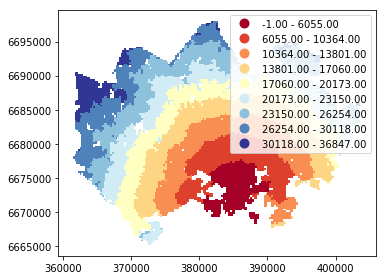

In [7]:
# Plot walking distance
acc.plot(column="walk_d", scheme="Fisher_Jenks", k=9, cmap="RdYlBu", linewidth=0, legend=True)

# Use tight layour
plt.tight_layout()

Okay, from here we can see that the walking distances (along road network) reminds more or less Euclidian distances.

- Let's apply one of the `Pysal` classifiers into our data and classify the travel times by public transport into 9 classes
- The classifier needs to be initialized first with `make()` function that takes the number of desired classes as input parameter


In [9]:
import pysal as ps

# Define the number of classes
n_classes = 9

# Create a Natural Breaks classifier
classifier = ps.Natural_Breaks.make(k=n_classes)

- Now we can apply that classifier into our data by using `apply` -function

In [10]:
# Classify the data
classifications = acc[['pt_r_tt']].apply(classifier)

# Let's see what we have
classifications.head()

,pt_r_tt
0,7
1,7
2,6
3,7
4,7


Okay, so now we have a DataFrame where our input column was classified into 9 different classes (numbers 1-9) based on [Natural Breaks classification](http://wiki-1-1930356585.us-east-1.elb.amazonaws.com/wiki/index.php/Jenks_Natural_Breaks_Classification).

- Now we want to join that reclassification into our original data but let's first rename the column so that we recognize it later on:


In [11]:
# Rename the column so that we know that it was classified with natural breaks
classifications.columns = ['nb_pt_r_tt']

# Join with our original data (here index is the key
acc = acc.join(classifications)

# Let's see how our data looks like
acc.head()

,car_m_d,car_m_t,car_r_d,car_r_t,from_id,pt_m_d,pt_m_t,pt_m_tt,pt_r_d,pt_r_t,...,to_id,walk_d,walk_t,GML_ID,NAMEFIN,NAMESWE,NATCODE,area,geometry,nb_pt_r_tt
0,15981,36,15988,41,6002702,14698,65,73,14698,61,...,5975375,14456,207,27517366,Helsinki,Helsingfors,091,62499.999976,"POLYGON ((391000.0001349226 6667750.00004299, ...",7
1,16190,34,16197,39,6002701,14661,64,73,14661,60,...,5975375,14419,206,27517366,Helsinki,Helsingfors,091,62499.999977,"POLYGON ((390750.0001349644 6668000.000042951,...",7
2,15727,33,15733,37,6001132,14256,59,69,14256,55,...,5975375,14014,200,27517366,Helsinki,Helsingfors,091,62499.999977,"POLYGON ((391000.0001349143 6668000.000042943,...",6
3,15975,33,15982,37,6001131,14512,62,73,14512,58,...,5975375,14270,204,27517366,Helsinki,Helsingfors,091,62499.999976,"POLYGON ((390750.0001349644 6668000.000042951,...",7
4,16136,35,16143,40,6001138,14730,65,73,14730,61,...,5975375,14212,203,27517366,Helsinki,Helsingfors,091,62499.999977,"POLYGON ((392500.0001346234 6668000.000042901,...",7


Great, now we have those values in our accessibility GeoDataFrame. Let's visualize the results and see how they look.

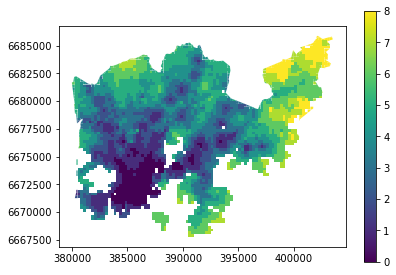

In [12]:
# Plot
acc.plot(column="nb_pt_r_tt", linewidth=0, legend=True)

# Use tight layout
plt.tight_layout()

And here we go, now we have a map where we have used one of the common classifiers to classify our data into 9 classes.

### Creating a custom classifier

**Multicriteria data classification**

Let's create a function where we classify the geometries into two classes based on a given `threshold` -parameter. If the area of a polygon is lower than the threshold value (average size of the lake), the output column will get a value 0, if it is larger, it will get a value 1. This kind of classification is often called a [binary classification](https://en.wikipedia.org/wiki/Binary_classification).

First we need to create a function for our classification task. This function takes a single row of the GeoDataFrame as input, plus few other parameters that we can use.

It also possible to do classifiers with multiple criteria easily in Pandas/Geopandas by extending the example that we started earlier. Now we will modify our binaryClassifier function a bit so that it classifies the data based on two columns.

- Let's call it `custom_classifier` that takes into account two criteria:


In [13]:
def custom_classifier(row, src_col1, src_col2, threshold1, threshold2, output_col):
   # 1. If the value in src_col1 is LOWER than the threshold1 value
   # 2. AND the value in src_col2 is HIGHER than the threshold2 value, give value 1, otherwise give 0
   if row[src_col1] < threshold1 and row[src_col2] > threshold2:
       # Update the output column with value 0
       row[output_col] = 1
   # If area of input geometry is higher than the threshold value update with value 1
   else:
       row[output_col] = 0

   # Return the updated row
   return row

Now we have defined the function, and we can start using it.

- Let's do our classification based on two criteria and find out grid cells where the **travel time is lower or equal to 20 minutes** but they are further away **than 4 km (4000 meters) from city center**.

- Let's create an empty column for our classification results called `"suitable_area"`.


In [14]:
# Create column for the classification results
acc["suitable_area"] = None

# Use the function
acc = acc.apply(custom_classifier, src_col1='pt_r_tt', 
                src_col2='walk_d', threshold1=20, threshold2=4000, 
                output_col="suitable_area", axis=1)

# See the first rows
acc.head(2)

,car_m_d,car_m_t,car_r_d,car_r_t,from_id,pt_m_d,pt_m_t,pt_m_tt,pt_r_d,pt_r_t,...,walk_d,walk_t,GML_ID,NAMEFIN,NAMESWE,NATCODE,area,geometry,nb_pt_r_tt,suitable_area
0,15981,36,15988,41,6002702,14698,65,73,14698,61,...,14456,207,27517366,Helsinki,Helsingfors,091,62499.999976,"POLYGON ((391000.0001349226 6667750.00004299, ...",7,0
1,16190,34,16197,39,6002701,14661,64,73,14661,60,...,14419,206,27517366,Helsinki,Helsingfors,091,62499.999977,"POLYGON ((390750.0001349644 6668000.000042951,...",7,0


Okey we have new values in `suitable_area` -column.

- How many Polygons are suitable for us? Let's find out by using a Pandas function called `value_counts()` that return the count of different values in our column.


In [15]:
# Get value counts
acc['suitable_area'].value_counts()

0    3808
1       9
Name: suitable_area, dtype: int64

Okay, so there seems to be nine suitable locations for us where we can try to find an appartment to buy.

- Let's see where they are located:


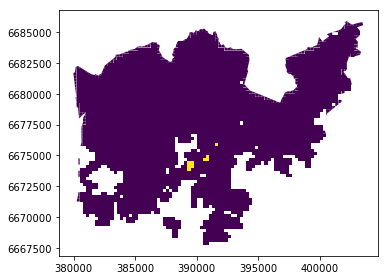

In [16]:
# Plot
acc.plot(column="suitable_area", linewidth=0);

# Use tight layour
plt.tight_layout()

A-haa, okay so we can see that suitable places for us with our criteria seem to be located in the
eastern part from the city center. Actually, those locations are along the metro line which makes them good locations in terms of travel time to city center since metro is really fast travel mode.
